1.12.0
[[22. 28.]
 [49. 64.]]


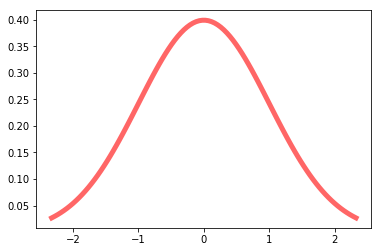

In [42]:
# set up anaconda environment (YMMV)
# conda create -n tensorflow python=3.6 anaconda
# conda activate tensorflow
# conda update --all
# conda install scipy pandas scikit-learn cython matplotlib plotly nose statsmodels ipykernel
# conda install -c  'conda-forge' xgboost catboost lightgbm
# pip install --ignore-installed --upgrade tensorflow_gpu-1.8.0-cp36-cp36m-linux_x86_64.whl
# conda update --all
# sudo /home/ubuntu/anaconda3/envs/tensorflow5/bin/python -m ipykernel install --name tensorflow
# sudo reboot

import time
from itertools import product
import random
random.seed(1744)

import numpy as np
#np.random.seed(1744)
from scipy.stats import norm, truncnorm
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils.testing import all_estimators

import statsmodels.discrete.discrete_model

# popular gradient boost algorithms
# XGBoost https://xgboost.readthedocs.io/en/latest/
# conda install -c conda-forge xgboost
import xgboost 
# Yandex CatBoost https://catboost.yandex/
# conda install -c conda-forge catboost
import catboost 
# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
# conda install -c conda-forge lightgbm
import lightgbm as lgb 

import tensorflow as tf
#tf.set_random_seed(1744)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

sess = tf.Session()
print (sess.run(c))

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense, Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
K.set_session(sess)
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

In [43]:
npoints = 2000
distspec0 = [25, 25, 50]
distspec1 = [80,80,20]

def gen_data(distspec0, distspec1, npoints):
    # create 100x100 grid
    # distro centered at 25,25, with normal distribution sd 50, truncate at 0 and 100
    locx, locy, my_std = distspec0
    # define clip a,b in terms of locx, my_std
    clipmin, clipmax=0,100
    a, b = (clipmin - locx) / my_std, (clipmax - locx) / my_std
    var1_x = truncnorm.rvs(a,b, loc=locx, scale=my_std, size=npoints)
    a, b = (clipmin - locy) / my_std, (clipmax - locy) / my_std
    var1_y = truncnorm.rvs(a,b, loc=locy, scale=my_std, size=npoints)
    class1 = np.array([var1_x,var1_y, [0]*npoints]).T
    print(class1.shape)

    # 2nd distro centered at 80, 80, sd 20, to create a nonlinear decision boundary
    locx, locy, my_std = distspec1
    a, b = (clipmin - locx) / my_std, (clipmax - locx) / my_std
    var2_x = truncnorm.rvs(a,b, loc=locx, scale=my_std, size=npoints)
    a, b = (clipmin - locx) / my_std, (clipmax - locx) / my_std
    var2_y = truncnorm.rvs(a,b, loc=locx, scale=my_std, size=npoints)
    class2 = np.array([var2_x,var2_y, [1]*npoints]).T
    print(class2.shape)

    # combine 2 distros for some kurtosis
    #tmp1_x = truncnorm.rvs(-3,1, loc=75, scale=25, size=npoints//2 )
    #tmp1_y = truncnorm.rvs(-3,1, loc=75, scale=25, size=npoints//2)
    #tmp2_x = truncnorm.rvs(-4,1, loc=80, scale=20, size=npoints//2 )
    #tmp2_y = truncnorm.rvs(-4,1, loc=80, scale=20, size=npoints//2)
    #var2_x = np.vstack([tmp1_x, tmp2_x]).T
    #var2_y = np.vstack([tmp1_y, tmp2_y]).T
    #class2 = np.vstack([var2_x,var2_y])
    #print(class2.shape)
    #class2 = np.hstack([class2, np.array([1]*npoints).reshape(npoints,1)])
    #print(class2.shape)
    
    data = np.vstack([class1, class2])
    print(data.shape)
    return data, class1, class2

data, class1, class2 = gen_data(distspec0, distspec1, npoints)
cvdata, class1_cv, class2_cv = gen_data(distspec0, distspec1, npoints)
testdata, class1_test, class2_test = gen_data(distspec0, distspec1, npoints)

pd.DataFrame(data, columns=['x', 'y', 'class'])

(2000, 3)
(2000, 3)
(4000, 3)
(2000, 3)
(2000, 3)
(4000, 3)
(2000, 3)
(2000, 3)
(4000, 3)


x          y  class
0     77.028965  44.633012    0.0
1     20.234672  79.649277    0.0
2     74.443987   0.072131    0.0
3     49.183170  32.534759    0.0
4     41.357747  54.267484    0.0
5     90.542187  49.961864    0.0
6     94.351831  97.503748    0.0
7     67.110623  20.660059    0.0
8     20.051699  64.124479    0.0
9     28.459665  10.587616    0.0
10    24.665137  44.746889    0.0
11    39.146758  75.169634    0.0
12    18.504227  36.984593    0.0
13    18.780058  15.604821    0.0
14    40.738722  56.260368    0.0
15     6.436523  35.693414    0.0
16     2.979889  37.354586    0.0
17     0.858566  87.972373    0.0
18    38.427857  80.756437    0.0
19    59.030596  24.227004    0.0
20    41.225042  55.185357    0.0
21    54.953089  16.926418    0.0
22    57.700715  32.923033    0.0
23     7.042051  32.424746    0.0
24     5.799115  38.216147    0.0
25    33.614047  64.914928    0.0
26    18.917859  95.440515    0.0
27     4.217638  24.602670    0.0
28    76.276074  76.328312    0.0
29    27.330883  19.601166    0.0
...         ...        ...    ...
3970  61.215169  66.917213    1.0
3971  85.553828  76.554843    1.0
3972  77.643568  69.819773    1.0
3973  88.698715  99.263687    1.0
3974  57.536659  76.300480    1.0
3975  82.199589  59.946272    1.0
3976  36.596495  65.579181    1.0
3977  98.512929  93.081146    1.0
3978  52.711905  83.563456    1.0
3979  80.879970  60.606059    1.0
3980  86.895794  93.223812    1.0
3981  73.525673  87.076528    1.0
3982  99.626518  37.241251    1.0
3983  95.043709  91.748089    1.0
3984  64.310563  64.866413    1.0
3985  68.359286  80.314113    1.0
3986  84.492621  65.364366    1.0
3987  56.507619  79.358641    1.0
3988  56.654195  84.548040    1.0
3989  46.064673  81.539138    1.0
3990  92.744321  89.871094    1.0
3991  81.136615  68.508897    1.0
3992  69.756958  79.747427    1.0
3993  90.961253  82.720054    1.0
3994  95.431337  64.384316    1.0
3995  70.001141  66.240823    1.0
3996  64.179204  83.300069    1.0
3997  63.872830  81.739165    1.0
3998  75.638132  75.993086    1.0
3999  27.452320  48.537309    1.0

[4000 rows x 3 columns]

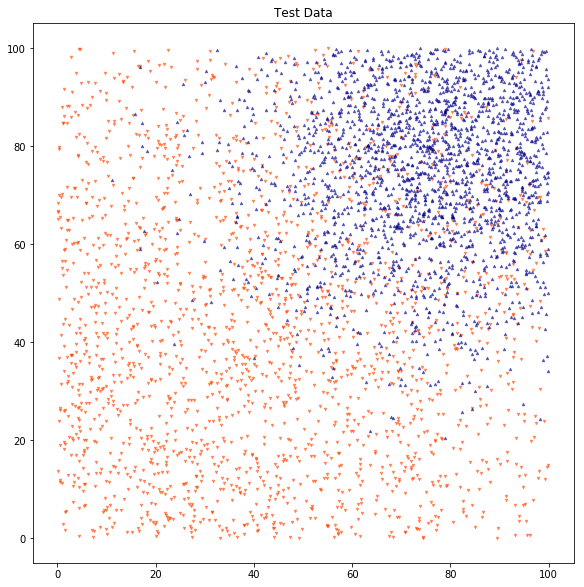

In [44]:
def class_chart(X1, X2, probas, title=""):
    
    trace1 = Scatter(
        x = X1[:,0],
        y = X1[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="orangered"
        )
    )

    trace2 = Scatter(
        x = X2[:,0],
        y = X2[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="darkblue"
        )
    )
    data = [trace1, trace2]

    if probas is not None:
        trace3 = Scatter(
            x = probas[:,0],
            y = probas[:,1],
            mode = 'markers',
            marker = dict(
                size = 4,
                opacity = 0.5*abs(probas[:,2]-0.5),
                color = probas[:,2]-0.5,
                colorscale=[[0.0, 'rgb(165,0,38)'], 
                            [0.1111111111111111, 'rgb(215,48,39)'], 
                            [0.2222222222222222, 'rgb(244,109,67)'], 
                            [0.3333333333333333, 'rgb(253,174,97)'], 
                            [0.4444444444444444, 'rgb(254,224,144)'], 
                            [0.5555555555555556, 'rgb(224,243,248)'], 
                            [0.6666666666666666, 'rgb(171,217,233)'], 
                            [0.7777777777777778, 'rgb(116,173,209)'], 
                            [0.8888888888888888, 'rgb(69,117,180)'], 
                            [1.0, 'rgb(49,54,149)']],                
                symbol = 'square'
            )
        )
        
        data = [trace1, trace2, trace3]
        
    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=640,
        showlegend=False,
        xaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        )
    )

    fig = Figure(data=data, layout=layout)

    return iplot(fig)

# plotly may slow down the browser with this many complex charts
# also doesn't render in github because it's all JS

dpi = 96

def class_chart_matplotlib(X1, X2, probas, title="", widget=None, markersize=6, bgsize=20):
    if widget is None:
        fig, widget = plt.subplots(figsize=(931/dpi,954/dpi))
    #plt.figure(figsize=(12,12))
    widget.scatter(X1[:,0], X1[:,1], s=markersize, c='orangered', marker='v', alpha=0.5)
    widget.scatter(X2[:,0], X2[:,1], s=markersize, c='darkblue', marker='^', alpha=0.5)
    if probas is not None:
        widget.scatter(probas[:,0], probas[:,1], c=probas[:,2]-0.5, cmap="bwr", marker='s', s=bgsize, alpha=0.15)
    if title:
        widget.set_title(title)
    
    #plt.show()

class_chart_matplotlib(class1, class2, None, "Test Data")

In [45]:
class_chart(class1, class2, None, "Test Data")

In [46]:
X = data[:, :2]
y = data[:, 2]

X_cv = cvdata[:, :2]
y_cv = cvdata[:, 2]

X_test = testdata[:, :2]
y_test = testdata[:, 2]

# predictors generated over whole grid to shade probs
X_pred = np.array(list(product(np.linspace(0,100,101),np.linspace(0,100,101))))



In-Sample Accuracy: 0.8468
Out-Of-Sample Accuracy: 0.8488
Confusion Matrix:
[[1623  377]
 [ 228 1772]]
(True negative 1623 True positive 1772 False positive 228 False negative 377)


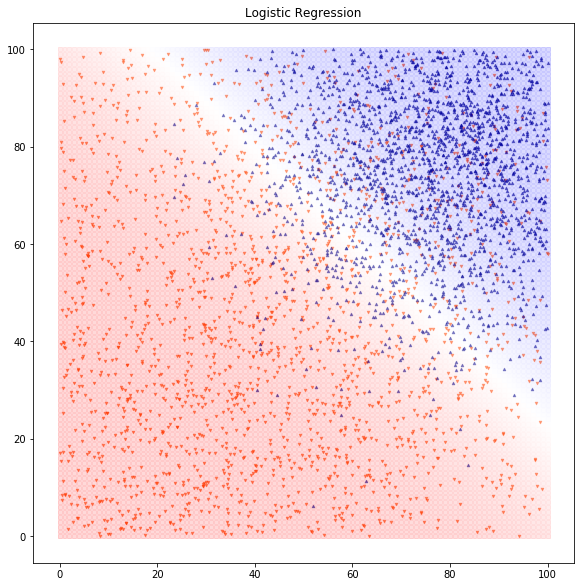

In [47]:
est = LogisticRegression(solver='lbfgs')
est.fit(X, y)
y_pred = est.predict(X)

print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
y_test_pred = est.predict(X_test)
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

z = est.predict_proba(X_pred)
Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "Logistic Regression", bgsize=15)    

In [48]:
class_chart(class1_test, class2_test, Z, "Logistic Regression")    

0.06088089019978073 0.06415098203820488 -7.562848433550354


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in less



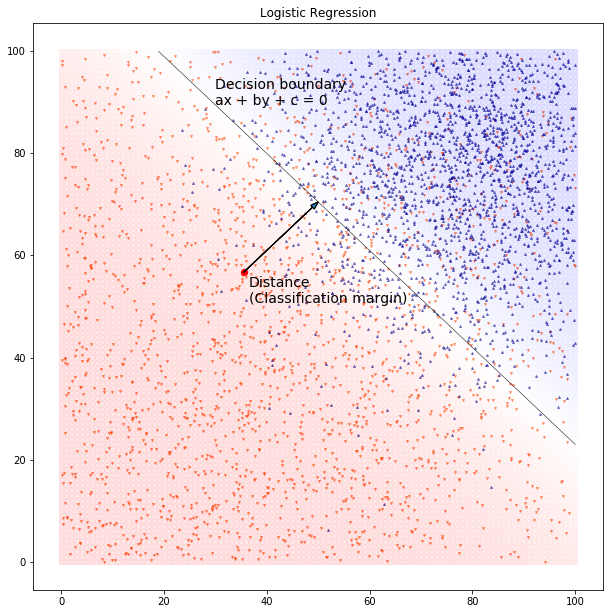

In [49]:
a, b = (est.coef_[0,0], est.coef_[0,1])
c = est.intercept_[0]
print(a,b,c)
my_x = np.linspace(0,100,101)
my_y = (-c - a * my_x)/b
my_y[my_y > 100.5] = np.nan
my_y[my_y < 0.5] = np.nan

dpi = 96
fig, widget = plt.subplots(figsize=(981/dpi,1001/dpi))
widget.scatter(class1_test[:,0], class1_test[:,1], s=4, c='orangered', marker='v', alpha=0.5)
widget.scatter(class2_test[:,0], class2_test[:,1], s=4, c='darkblue', marker='^', alpha=0.5)
widget.scatter(Z[:,0], Z[:,1], c=Z[:,2]-0.5, cmap="bwr", marker='s', s=17, alpha=0.1)
widget.plot(my_x, my_y, c='black', lw=0.5)
widget.set_title("Logistic Regression")

vec_xlength, vec_ylength = -b / np.sqrt(b**2 + a**2) *20, -a / np.sqrt(b**2 + a**2) *20
widget.arrow(my_x[50]+ vec_xlength, my_y[50] + vec_ylength, -vec_xlength, -vec_ylength, head_width=1, length_includes_head=True)
widget.scatter(x=my_x[50]+ vec_xlength, y=my_y[50]+vec_ylength, c='red', s=40, label='point')
widget.text(x=my_x[50]+ vec_xlength+1, y=my_y[50]+vec_ylength-6, s='Distance\n(Classification margin)', fontsize=14)
widget.text(x=my_x[30], y=my_y[30], s='Decision boundary\nax + by + c = 0', fontsize=14)

widget.arrow(my_x[50]+ vec_xlength, my_y[50] + vec_ylength, -vec_xlength, -vec_ylength, head_width=1, length_includes_head=True)


In [52]:
def class_chart_with_annotations(X1, X2, probas, title=""):
    
    trace1 = Scatter(
        x = X1[:,0],
        y = X1[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="orangered"
        )
    )

    trace2 = Scatter(
        x = X2[:,0],
        y = X2[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="darkblue"
        )
    )
    data = [trace1, trace2]

    if probas is not None:
        trace3 = Scatter(
            x = probas[:,0],
            y = probas[:,1],
            mode = 'markers',
            marker = dict(
                size = 4,
                opacity = 0.5*abs(probas[:,2]-0.5),
                color = probas[:,2]-0.5,
                colorscale=[[0.0, 'rgb(165,0,38)'], 
                            [0.1111111111111111, 'rgb(215,48,39)'], 
                            [0.2222222222222222, 'rgb(244,109,67)'], 
                            [0.3333333333333333, 'rgb(253,174,97)'], 
                            [0.4444444444444444, 'rgb(254,224,144)'], 
                            [0.5555555555555556, 'rgb(224,243,248)'], 
                            [0.6666666666666666, 'rgb(171,217,233)'], 
                            [0.7777777777777778, 'rgb(116,173,209)'], 
                            [0.8888888888888888, 'rgb(69,117,180)'], 
                            [1.0, 'rgb(49,54,149)']],                
                symbol = 'square'
            )
        )
        
        data.append(trace3)

    trace4 = Scatter(
        x = my_x,
        y = my_y,
        mode = 'lines',
        line = dict(
            color = ('black'),
            width = 2)
    )        
    data.append(trace4)
        
    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=640,
        showlegend=False,
        xaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        ),
        annotations=[
            dict(
                x=my_x[70],
                y=my_y[70],
                xref='x',
                yref='y',
                text='Decision Boundary: ax + by + c = 0',
                showarrow=True,
                font=dict(
                    family='Arial, sans-serif',
                    size=16,
                    color='black'
                ),
                align='center',
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor='#333333',
                ax=-20,
                ay=60,
                bordercolor='#c7c7c7',
                borderwidth=2,
                borderpad=4,
                bgcolor='#ff7f0e',
                opacity=0.75
            ),
            dict(
                x=my_x[50],
                y=my_y[50],
                xref='x',
                yref='y',
                text='Distance to boundary',
                showarrow=True,
                font=dict(
                    family='Arial, sans-serif',
                    size=16,
                    color='black'
                ),
                align='center',
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor='#333333',
                ax=-vec_xlength*5,
                ay= vec_ylength*5,
                bordercolor='#c7c7c7',
                borderwidth=2,
                borderpad=4,
                bgcolor='#ff7f0e',
                opacity=0.75
            ),
            
        ]
    )        

    fig = Figure(data=data, layout=layout)

    return iplot(fig)

class_chart_with_annotations(class1, class2, Z, "Logistic Regression")

0.25
0.5
0.75


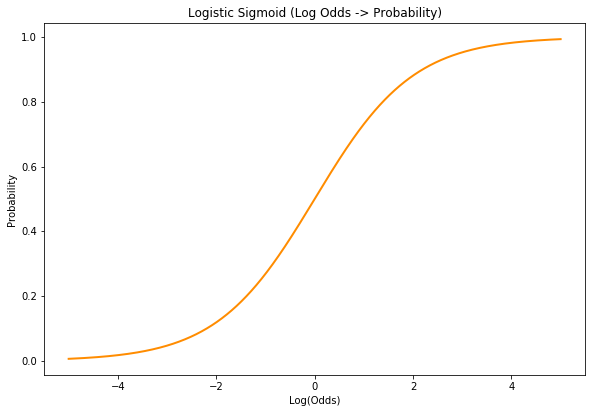

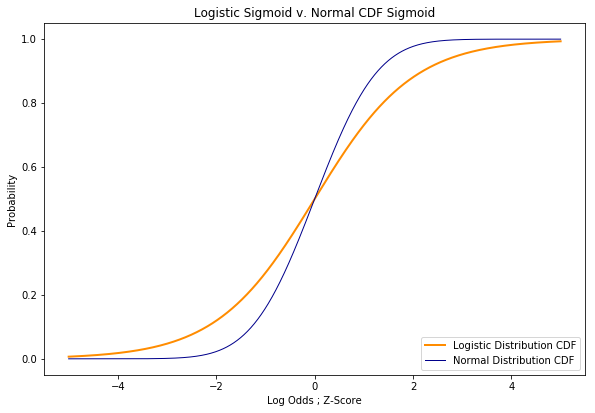

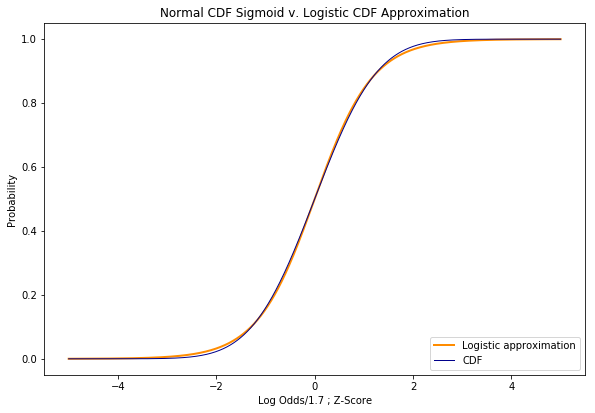

In [60]:
def logistic_sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

print(logistic_sigmoid(np.log(1/3)))
print(logistic_sigmoid(0))
print(logistic_sigmoid(np.log(3)))

x_dist = np.linspace(-5, 5, 1000)
y_logistic = logistic_sigmoid(x_dist)
y_logistic_approx = logistic_sigmoid(x_dist*1.7)
y_normcdf = norm.cdf(x_dist)

plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, y_logistic, lw=2, c='darkorange', alpha=1)
plt.ylabel('Probability')
plt.xlabel('Log(Odds)')
plt.title('Logistic Sigmoid (Log Odds -> Probability)')
plt.show()

plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, y_logistic, lw=2, c='darkorange', alpha=1, label = 'Logistic Distribution CDF')
plt.plot(x_dist, y_normcdf, lw=1, c='darkblue', alpha=1, label = 'Normal Distribution CDF')
plt.legend(loc="lower right")
plt.ylabel('Probability')
plt.xlabel('Log Odds ; Z-Score')
plt.title('Logistic Sigmoid v. Normal CDF Sigmoid')
plt.show()

plt.rcParams['text.usetex'] = 'false'
plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, y_logistic_approx, lw=2, c='darkorange', alpha=1, label = 'Logistic approximation')
plt.plot(x_dist, y_normcdf, lw=1, c='darkblue', alpha=1, label = 'CDF')
plt.legend(loc="lower right")
plt.ylabel('Probability')
plt.xlabel('Log Odds/1.7 ; Z-Score')
plt.title('Normal CDF Sigmoid v. Logistic CDF Approximation')
plt.show()

In [61]:
x_dist

array([-5.        , -4.98998999, -4.97997998, -4.96996997, -4.95995996,
       -4.94994995, -4.93993994, -4.92992993, -4.91991992, -4.90990991,
       -4.8998999 , -4.88988989, -4.87987988, -4.86986987, -4.85985986,
       -4.84984985, -4.83983984, -4.82982983, -4.81981982, -4.80980981,
       -4.7997998 , -4.78978979, -4.77977978, -4.76976977, -4.75975976,
       -4.74974975, -4.73973974, -4.72972973, -4.71971972, -4.70970971,
       -4.6996997 , -4.68968969, -4.67967968, -4.66966967, -4.65965966,
       -4.64964965, -4.63963964, -4.62962963, -4.61961962, -4.60960961,
       -4.5995996 , -4.58958959, -4.57957958, -4.56956957, -4.55955956,
       -4.54954955, -4.53953954, -4.52952953, -4.51951952, -4.50950951,
       -4.4994995 , -4.48948949, -4.47947948, -4.46946947, -4.45945946,
       -4.44944945, -4.43943944, -4.42942943, -4.41941942, -4.40940941,
       -4.3993994 , -4.38938939, -4.37937938, -4.36936937, -4.35935936,
       -4.34934935, -4.33933934, -4.32932933, -4.31931932, -4.30

In [68]:
def line_chart(x1, y1, title="", ytitle="", xtitle=""):
    
    trace1 = Scatter(
        x = x1,
        y = y1,
        mode = 'lines',
    )

    data = [trace1]

    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=480,
        showlegend=False,
        yaxis=dict(
            dtick=0.1,
            title=ytitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey',
            ),
        ),
        xaxis=dict(
            dtick=1,
            title=xtitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey'
            ),        
        )
    )
    fig = Figure(data=data, layout=layout)

    return iplot(fig)

line_chart(x_dist, y_logistic, "Logistic Sigmoid", 'Probability', 'Log(Odds)')

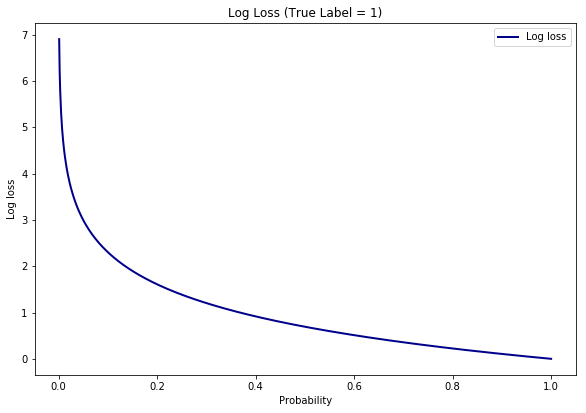

In [69]:
x_dist = np.linspace(0.001, 1, 1000)
log_loss = -np.log(x_dist)

plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, log_loss, lw=2, c='darkblue', alpha=1, label = 'Log loss')
plt.legend(loc="upper right")
plt.ylabel('Log loss')
plt.xlabel('Probability')
plt.title('Log Loss (True Label = 1)')
plt.show()

In [77]:
def line_chart(x1, y1, title="", ytitle="", xtitle=""):
    
    trace1 = Scatter(
        x = x1,
        y = y1,
        mode = 'lines',
    )

    data = [trace1]

    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=480,
        showlegend=False,
        yaxis=dict(
            range=[0, 6],
            linecolor='black',
            mirror=True,
            title=ytitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey',
            ),
        ),
        xaxis=dict(
            linecolor='black',
            mirror=True,
            title=xtitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey'
            ),        
        )
    )
    fig = Figure(data=data, layout=layout)

    return iplot(fig)


line_chart(x_dist, log_loss, "Log Loss (True Label = 1)", 'Log Loss', 'Predicted Probability')

[[50 50]]
[[0.78772306 0.21227694]]
[0.]
[-1.31125482]
[0.21227694]
AUC: 0.9176


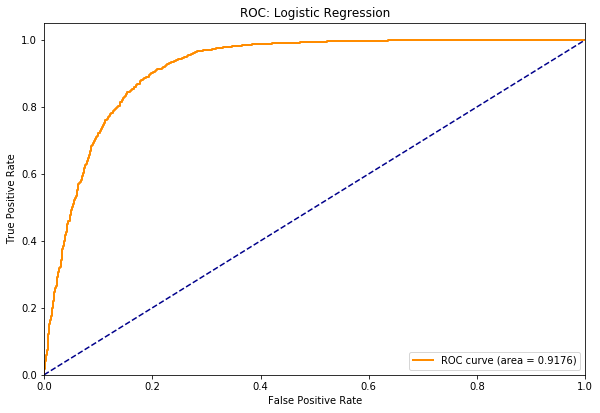

0.9175847500000001

In [78]:
# ROC curve

XX = np.array([50,  50]).reshape(1,2)
print(XX)
print(est.predict_proba(XX))
print(est.predict(XX))
print(est.decision_function(XX))
print(1 / (1 + np.exp(-est.decision_function(XX))))

def roc_chart(est, X_test, y_test, title):
    y_pred_prob = est.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_val = auc(fpr, tpr)
    print("AUC: %.4f" % auc_val)
    
    plt.figure(figsize=(931/dpi,621/dpi))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return auc_val

roc_chart(est, X_test, y_test, "ROC: Logistic Regression")

In [90]:
def plotly_roc_chart(est, X_test, y_test, title="", ytitle="", xtitle=""):
    y_pred_prob = est.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_val = auc(fpr, tpr)
    print("AUC: %.4f" % auc_val)
    
    trace1 = Scatter(
        x = fpr,
        y = tpr,
        mode = 'lines',
    )

    data = [trace1]

    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=480,
        showlegend=False,
        yaxis=dict(
            linecolor='black',
            mirror=True,
            title=ytitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey',
            ),
        ),
        xaxis=dict(
            linecolor='black',
            mirror=True,
            title=xtitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey'
            ),        
        ),
        annotations=[
            dict(
                x=0.9,
                y=0.05,
                text="AUC: %.4f" % auc_val,
                showarrow=False,
        )
    ]        
    )
    fig = Figure(data=data, layout=layout)

    return iplot(fig)


plotly_roc_chart(est, X_test, y_test, "ROC: Logistic Regression", "True Positive Rate", "False Positive Rate")

AUC: 0.9176


In [13]:
y_pred_prob = est.predict_proba(X)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
for thresh in thresholds:
    my_y_pred = y_pred_prob > thresh
    acc = sklearn.metrics.accuracy_score(y_test, my_y_pred)
    f1_score = sklearn.metrics.f1_score(y_test, my_y_pred)
    print("Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

def select_threshold(y_test, y_pred_prob, metric_fn):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    metric_list = []
    for i, thresh in enumerate(thresholds):
        my_y_pred = y_pred_prob > thresh
        metric = metric_fn(y_test, my_y_pred)
        metric_list.append(metric)
    return thresholds[np.argmax(metric_list)]

print("")
thresh = select_threshold(y_test, y_pred_prob, sklearn.metrics.accuracy_score)
my_y_pred = y_pred_prob > thresh
acc = sklearn.metrics.accuracy_score(y_test, my_y_pred)
f1_score = sklearn.metrics.f1_score(y_test, my_y_pred)
print("Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

print("")
thresh = select_threshold(y_test, y_pred_prob, sklearn.metrics.f1_score)
my_y_pred = y_pred_prob > thresh
acc = sklearn.metrics.accuracy_score(y_test, my_y_pred)
f1_score = sklearn.metrics.f1_score(y_test, my_y_pred)
print("Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))



Threshold 1.9901 Accuracy 0.5000 F1 0.0000
Threshold 0.9901 Accuracy 0.5000 F1 0.0000
Threshold 0.9831 Accuracy 0.5108 F1 0.0421
Threshold 0.9830 Accuracy 0.5110 F1 0.0431
Threshold 0.9814 Accuracy 0.5132 F1 0.0526
Threshold 0.9813 Accuracy 0.5135 F1 0.0535
Threshold 0.9808 Accuracy 0.5140 F1 0.0563
Threshold 0.9807 Accuracy 0.5142 F1 0.0573
Threshold 0.9807 Accuracy 0.5145 F1 0.0591
Threshold 0.9807 Accuracy 0.5148 F1 0.0600
Threshold 0.9797 Accuracy 0.5162 F1 0.0666
Threshold 0.9797 Accuracy 0.5165 F1 0.0675
Threshold 0.9789 Accuracy 0.5175 F1 0.0721
Threshold 0.9788 Accuracy 0.5178 F1 0.0730
Threshold 0.9780 Accuracy 0.5202 F1 0.0831
Threshold 0.9780 Accuracy 0.5205 F1 0.0840
Threshold 0.9760 Accuracy 0.5258 F1 0.1039
Threshold 0.9760 Accuracy 0.5260 F1 0.1048
Threshold 0.9759 Accuracy 0.5258 F1 0.1048
Threshold 0.9759 Accuracy 0.5260 F1 0.1057
Threshold 0.9757 Accuracy 0.5262 F1 0.1074
Threshold 0.9756 Accuracy 0.5265 F1 0.1083
Threshold 0.9751 Accuracy 0.5280 F1 0.1144
Threshold 0

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



Threshold 0.9734 Accuracy 0.5298 F1 0.1239
Threshold 0.9733 Accuracy 0.5300 F1 0.1248
Threshold 0.9728 Accuracy 0.5305 F1 0.1273
Threshold 0.9727 Accuracy 0.5308 F1 0.1282
Threshold 0.9723 Accuracy 0.5312 F1 0.1307
Threshold 0.9722 Accuracy 0.5315 F1 0.1316
Threshold 0.9655 Accuracy 0.5503 F1 0.1951
Threshold 0.9654 Accuracy 0.5505 F1 0.1959
Threshold 0.9654 Accuracy 0.5503 F1 0.1958
Threshold 0.9651 Accuracy 0.5503 F1 0.1965
Threshold 0.9641 Accuracy 0.5520 F1 0.2028
Threshold 0.9637 Accuracy 0.5523 F1 0.2036
Threshold 0.9625 Accuracy 0.5550 F1 0.2131
Threshold 0.9624 Accuracy 0.5553 F1 0.2139
Threshold 0.9615 Accuracy 0.5575 F1 0.2216
Threshold 0.9615 Accuracy 0.5577 F1 0.2224
Threshold 0.9588 Accuracy 0.5645 F1 0.2439
Threshold 0.9586 Accuracy 0.5647 F1 0.2447
Threshold 0.9581 Accuracy 0.5653 F1 0.2469
Threshold 0.9581 Accuracy 0.5655 F1 0.2476
Threshold 0.9580 Accuracy 0.5657 F1 0.2490
Threshold 0.9579 Accuracy 0.5660 F1 0.2498
Threshold 0.9566 Accuracy 0.5685 F1 0.2580
Threshold 0

Threshold 0.8164 Accuracy 0.7545 F1 0.6991
Threshold 0.8162 Accuracy 0.7542 F1 0.6989
Threshold 0.8157 Accuracy 0.7545 F1 0.6993
Threshold 0.8115 Accuracy 0.7570 F1 0.7035
Threshold 0.8114 Accuracy 0.7572 F1 0.7039
Threshold 0.8109 Accuracy 0.7572 F1 0.7041
Threshold 0.8108 Accuracy 0.7572 F1 0.7042
Threshold 0.8084 Accuracy 0.7595 F1 0.7080
Threshold 0.8082 Accuracy 0.7598 F1 0.7083
Threshold 0.8052 Accuracy 0.7608 F1 0.7101
Threshold 0.8048 Accuracy 0.7610 F1 0.7105
Threshold 0.8016 Accuracy 0.7638 F1 0.7149
Threshold 0.8013 Accuracy 0.7640 F1 0.7153
Threshold 0.7998 Accuracy 0.7652 F1 0.7174
Threshold 0.7995 Accuracy 0.7655 F1 0.7178
Threshold 0.7970 Accuracy 0.7668 F1 0.7199
Threshold 0.7969 Accuracy 0.7670 F1 0.7203
Threshold 0.7956 Accuracy 0.7672 F1 0.7208
Threshold 0.7954 Accuracy 0.7672 F1 0.7210
Threshold 0.7935 Accuracy 0.7685 F1 0.7231
Threshold 0.7933 Accuracy 0.7685 F1 0.7233
Threshold 0.7915 Accuracy 0.7698 F1 0.7253
Threshold 0.7914 Accuracy 0.7700 F1 0.7257
Threshold 0

Threshold 0.6211 Accuracy 0.8347 F1 0.8295
Threshold 0.6205 Accuracy 0.8343 F1 0.8292
Threshold 0.6197 Accuracy 0.8340 F1 0.8290
Threshold 0.6196 Accuracy 0.8343 F1 0.8293
Threshold 0.6192 Accuracy 0.8343 F1 0.8293
Threshold 0.6176 Accuracy 0.8345 F1 0.8296
Threshold 0.6169 Accuracy 0.8345 F1 0.8297
Threshold 0.6164 Accuracy 0.8347 F1 0.8300
Threshold 0.6157 Accuracy 0.8347 F1 0.8301
Threshold 0.6154 Accuracy 0.8350 F1 0.8304
Threshold 0.6149 Accuracy 0.8350 F1 0.8305
Threshold 0.6147 Accuracy 0.8353 F1 0.8308
Threshold 0.6118 Accuracy 0.8353 F1 0.8309
Threshold 0.6114 Accuracy 0.8353 F1 0.8310
Threshold 0.6104 Accuracy 0.8350 F1 0.8308
Threshold 0.6102 Accuracy 0.8353 F1 0.8311
Threshold 0.6096 Accuracy 0.8350 F1 0.8309
Threshold 0.6071 Accuracy 0.8345 F1 0.8305
Threshold 0.6050 Accuracy 0.8355 F1 0.8318
Threshold 0.6041 Accuracy 0.8357 F1 0.8321
Threshold 0.6029 Accuracy 0.8360 F1 0.8325
Threshold 0.6007 Accuracy 0.8357 F1 0.8324
Threshold 0.6004 Accuracy 0.8357 F1 0.8324
Threshold 0

Threshold 0.3923 Accuracy 0.8423 F1 0.8539
Threshold 0.3910 Accuracy 0.8425 F1 0.8542
Threshold 0.3902 Accuracy 0.8427 F1 0.8545
Threshold 0.3882 Accuracy 0.8425 F1 0.8544
Threshold 0.3882 Accuracy 0.8423 F1 0.8542
Threshold 0.3881 Accuracy 0.8425 F1 0.8544
Threshold 0.3881 Accuracy 0.8423 F1 0.8542
Threshold 0.3864 Accuracy 0.8425 F1 0.8545
Threshold 0.3862 Accuracy 0.8423 F1 0.8543
Threshold 0.3858 Accuracy 0.8425 F1 0.8546
Threshold 0.3850 Accuracy 0.8425 F1 0.8546
Threshold 0.3844 Accuracy 0.8427 F1 0.8549
Threshold 0.3841 Accuracy 0.8425 F1 0.8547
Threshold 0.3811 Accuracy 0.8423 F1 0.8546
Threshold 0.3804 Accuracy 0.8420 F1 0.8544
Threshold 0.3786 Accuracy 0.8417 F1 0.8542
Threshold 0.3774 Accuracy 0.8417 F1 0.8543
Threshold 0.3772 Accuracy 0.8420 F1 0.8546
Threshold 0.3770 Accuracy 0.8417 F1 0.8544
Threshold 0.3758 Accuracy 0.8417 F1 0.8544
Threshold 0.3703 Accuracy 0.8438 F1 0.8566
Threshold 0.3698 Accuracy 0.8440 F1 0.8569
Threshold 0.3694 Accuracy 0.8438 F1 0.8567
Threshold 0

Threshold 0.0606 Accuracy 0.7165 F1 0.7783
Threshold 0.0606 Accuracy 0.7163 F1 0.7782
Threshold 0.0595 Accuracy 0.7157 F1 0.7780
Threshold 0.0591 Accuracy 0.7155 F1 0.7778
Threshold 0.0547 Accuracy 0.7087 F1 0.7738
Threshold 0.0546 Accuracy 0.7085 F1 0.7737
Threshold 0.0509 Accuracy 0.7037 F1 0.7709
Threshold 0.0507 Accuracy 0.7035 F1 0.7708
Threshold 0.0498 Accuracy 0.7017 F1 0.7698
Threshold 0.0495 Accuracy 0.7015 F1 0.7697
Threshold 0.0441 Accuracy 0.6907 F1 0.7634
Threshold 0.0440 Accuracy 0.6905 F1 0.7633
Threshold 0.0422 Accuracy 0.6865 F1 0.7611
Threshold 0.0421 Accuracy 0.6863 F1 0.7609
Threshold 0.0157 Accuracy 0.6145 F1 0.7216
Threshold 0.0157 Accuracy 0.6142 F1 0.7214
Threshold 0.0054 Accuracy 0.5493 F1 0.6892
Threshold 0.0053 Accuracy 0.5490 F1 0.6891
Threshold 0.0007 Accuracy 0.5002 F1 0.6668

Threshold 0.4455 Accuracy 0.8460 F1 0.8539



/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



Threshold 0.3698 Accuracy 0.8440 F1 0.8569


In-Sample Accuracy (50% threshold): 0.8442


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



CV Threshold 0.4927 Accuracy 0.8568 F1 0.8618
Out-Of-Sample Accuracy: 0.8462
Confusion Matrix:
[[1623  377]
 [ 238 1762]]
(True negative 1623 True positive 1762 False positive 238 False negative 377)
              precision    recall  f1-score   support

         0.0     0.8721    0.8115    0.8407      2000
         1.0     0.8237    0.8810    0.8514      2000

   micro avg     0.8462    0.8462    0.8462      4000
   macro avg     0.8479    0.8462    0.8461      4000
weighted avg     0.8479    0.8462    0.8461      4000

AUC: 0.9103


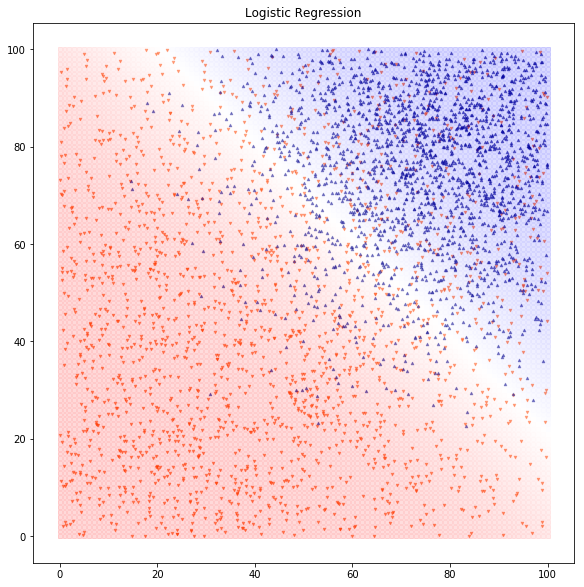

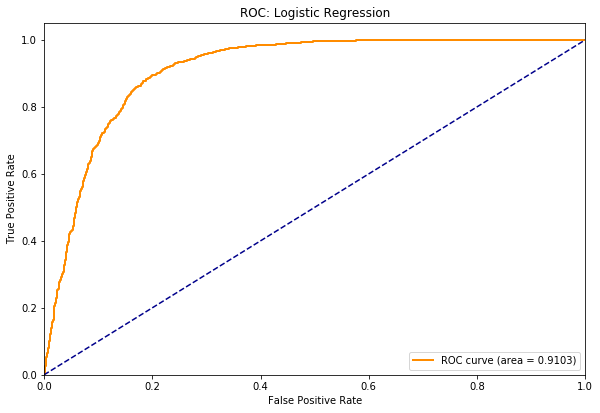

0.9103477500000001

In [14]:
# Template for binary classification with training, CV, and test sets

estimator = LogisticRegression
est = estimator()
est.fit(X, y)
y_pred = est.predict(X)
print("In-Sample Accuracy (50%% threshold): %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
# select threshold using CV data to maximize accuracy
y_cv_pred_prob = est.predict_proba(X_cv)[:,1]
thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
y_cv_pred = y_cv_pred_prob > thresh
acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

# evaluate estimator using test data
y_test_pred_prob = est.predict_proba(X_test)[:,1]
y_test_pred = y_test_pred_prob > thresh
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, digits=4))

z = est.predict_proba(X_pred)
Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "Logistic Regression", bgsize=15)   
roc_chart(est, X_test, y_test, "ROC: Logistic Regression")


In [15]:
# list all classifiers that support predict_proba 
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)
estimators

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.naive_bayes.ComplementNB'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_netwo

[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.naive_bayes.ComplementNB,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.naive_bayes.MultinomialNB,
 sklearn.svm.classes.NuSVC,
 sklearn.discriminant_analysis.Quadrati

In [16]:
# Wrappers for some non-sklearn models 
# and some sklearn models that need custom params

def myNuSVC():
    # needs probability=True
    return sklearn.svm.classes.NuSVC(probability=True)

def mySGDClassifierLog():
    # needs loss="log"
    return sklearn.linear_model.stochastic_gradient.SGDClassifier(loss="log", max_iter=1000, tol=1e-4)

def mySVC():
    # needs probability=True
    return sklearn.svm.classes.SVC(probability=True)

def myXGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    # needs nthreads=-1
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

def myCatBoostClassifier():
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

def myLGBMClassifier():
    def create_model():
        return lgb.LGBMClassifier(silent=True)
    return create_model

# statsmodels use a different interface from sklearn and I don't see a wrapper, so here's a wrapper
class SMwrapper:
    def __init__(self, smclass):
        self.smclass = smclass
        self.model=None
        self.result=None

    def fit(self, X, y_class):
        # statsmodels need an explicit intercept
        intercept = np.array([1] * len(X)).reshape(len(X),1)
        X = np.hstack([X,intercept])
        self.model = self.smclass(y_class, X)
        self.result = self.model.fit()
        
    def predict_proba(self, X_pred):
        intercept = np.array([1] * len(X_pred)).reshape(len(X_pred),1)
        X_pred = np.hstack([X_pred,intercept])
        self.y_pred_proba = self.result.predict(X_pred)
        retarray = np.array([1-self.y_pred_proba, self.y_pred_proba]).T        
        return retarray

    def predict(self, X_pred):
        intercept = np.array([1] * len(X_pred)).reshape(len(X_pred),1)
        X_pred = np.hstack([X_pred,intercept])
        self.y_pred_proba = self.result.predict(X_pred)
        #print("median %f" % np.median(self.y_pred_proba))
        #y_pred = self.y_pred_proba > np.median(self.y_pred_proba)
        y_pred = self.y_pred_proba > 0.5
        return y_pred
    
def statsmodels_wrapper(smclass):
    def create_smwrapper():
        return SMwrapper(smclass)
    return create_smwrapper

EPOCHS=1000
INPUT_DIM=2
def myKerasClassifier(n_hidden_layers = 2,
                      hidden_layer_size = 16,
                      reg_penalty = 0.0001,
                      epochs=EPOCHS,
                      verbose=True):
    
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        output = Dense(1, activation='sigmoid')(lastlayer)            
        model = Model(inputs=[main_input], outputs=[output])
        if verbose:
            print(model.summary())

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
    
def modelFactory(n_hidden_layers = 2,
                 hidden_layer_size = 16,
                 reg_penalty = 0.0001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return myKerasClassifier(n_hidden_layers,
                                 hidden_layer_size,
                                 reg_penalty,
                                 epochs,
                                 verbose)
    return create_fn

# KerasClassifier wraps a Keras model with an sklearn interface
# But it returns wrong shape for VotingClassifier ensemble
# 2D shape (nrows,1) instead of 1D (nrows) 
# Subclass KerasClassifier and override predict  

class monkeyKerasClassifier(KerasClassifier):
    """subclass KerasClassifier and override predict to work with VotingClassifier"""
    def __init__(self, *args, **kwargs):
        super(KerasClassifier, self).__init__(*args, **kwargs)        
        
    def predict(self, x, **kwargs):
        # this should work but nope
        # pred = KerasClassifier.predict(self, x, **kwargs)
        # return pred[:, 0]
        
        pred = self.model.predict(x, **kwargs)
        return np.round(pred[:,0])        

    def predict_proba(self, x, **kwargs):
        pred = self.model.predict(x, **kwargs)
        return np.vstack([1-pred[:,0], pred[:,0]]).T
    
def kerasClassifierFactory(n_hidden_layers = 2,
                           hidden_layer_size = 16,
                           reg_penalty = 0.0001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return monkeyKerasClassifier(build_fn=modelFactory(n_hidden_layers,
                                                     hidden_layer_size,
                                                     reg_penalty,
                                                     epochs,
                                                     verbose), 
                               epochs=EPOCHS, 
                               batch_size=100, 
                               verbose=0)
    return create_fn


layer 1 size 16, reg_penalty 0.00010000
layer 2 size 16, reg_penalty 0.00010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                48        
_________________________________________________________________
Dense01 (Dense)              (None, 16)                272       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None
In-Sample Accuracy: 0.8592
Out-Of-Sample Accuracy: 0.8558
Confusion Matrix:
[[1607  393]
 [ 184 1816]]
(True negative 1607 True positive 1816 False positive 184 False negative 393)
AUC: 0.916

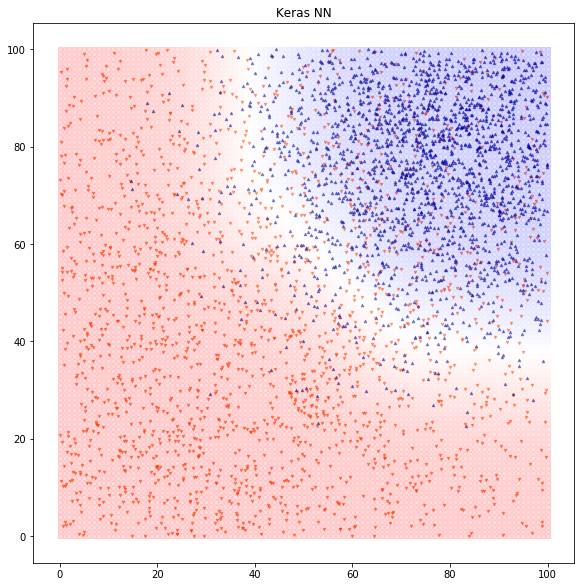

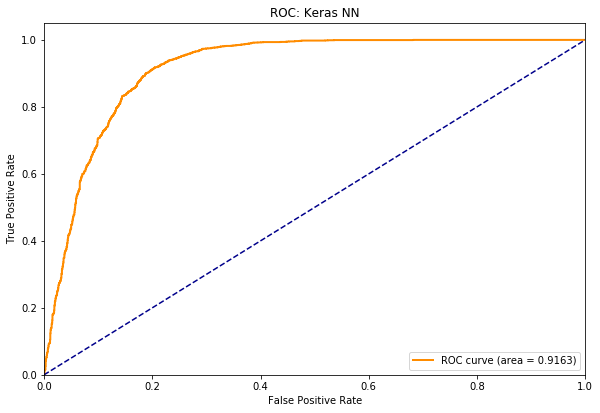

0.916300125

In [17]:
model = kerasClassifierFactory()()
#print(dir(model))
model.fit(X,y)

y_pred = model.predict(X)
print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
y_test_pred = model.predict(X_test)
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

z = model.predict_proba(X_pred)
if len(z.shape) == 1:
    z = z.reshape(z.shape[0], 1)

Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "Keras NN", bgsize=15)    
roc_chart(model, X_test, y_test, "ROC: Keras NN")

In [18]:
# cross-validate a bunch of keras models
n_layers = [1, 2, 3]
hidden_layer_sizes = [4, 8, 16, 32, 64]
reg_penaltys = [0, 0.0001, 0.001, 0.01, 0.1]

hyperparameter_combos = list(product(n_layers, hidden_layer_sizes, reg_penaltys))

keys = []
accuracies= []
aucs = []

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, hidden_layer_size, reg_penalty = param_list
    est = kerasClassifierFactory(n_hidden_layers=n_hidden_layers,
                                   hidden_layer_size=hidden_layer_size,
                                   reg_penalty=reg_penalty)()

    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, hidden_layer_size, reg_penalty)
    print(key)
    keys.append(key)
    est.fit(X, y)
    y_pred = est.predict(X)
    print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
    y_test_pred = est.predict(X_test)
    print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
    accuracies.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:")
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    print (conf_mat)
    print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

    z = est.predict_proba(X_pred)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1)

    Z = np.hstack([X_pred, z])
    estname="Keras NN %d layers, %d units %f reg_penalty" % (n_hidden_layers, hidden_layer_size, reg_penalty)
    class_chart_matplotlib(class1_test, class2_test, Z, estname, bgsize=15)    
    myauc = roc_chart(est, X_test, y_test, "ROC: %s" % estname)
    aucs.append(myauc)
    print()
    print('############################################################')
    print()
    

18:47:44 Running experiment 1 of 75
(1, 4, 0)
layer 1 size 4, reg_penalty 0.00000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
Dense00 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
None


KeyboardInterrupt: 

In [ ]:
#make dataframe
flatlist = []
for k, acc, myauc in zip(keys, accuracies, aucs):
    flatlist.append([k[0], k[1], k[2], acc, myauc, acc+myauc])
    
metricsframe = pd.DataFrame(flatlist, columns = ['layers', 'units', 'reg_penalty', 'acc', 'auc', 'comb'])

#sort by auc + accuracy
metricsframe.sort_values(['comb'], ascending=False)
#heatmap

In [ ]:
#summarize average by layers, units, reg_penalty

pd.DataFrame(metricsframe.groupby(['layers'])[['acc', 'auc', 'comb']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['units'])[['acc', 'auc', 'comb']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['acc', 'auc', 'comb']].mean())

In [ ]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['comb'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
#                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(metricsframe, "layers", "units", x_suffix=" layers", y_suffix=" units")
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")
plot_matrix(metricsframe, "reg_penalty", "units", x_suffix=" p", y_suffix="units")

In [ ]:

estimators = [sklearn.linear_model.logistic.LogisticRegression,
              sklearn.linear_model.logistic.LogisticRegressionCV,
              sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
              statsmodels_wrapper(statsmodels.discrete.discrete_model.Logit),
              statsmodels_wrapper(statsmodels.discrete.discrete_model.Probit),
              sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
              sklearn.neural_network.multilayer_perceptron.MLPClassifier,
              sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
              myXGBClassifier(),
              myCatBoostClassifier(),
              myLGBMClassifier(),
              sklearn.ensemble.weight_boosting.AdaBoostClassifier,
              sklearn.ensemble.bagging.BaggingClassifier,
              sklearn.tree.tree.DecisionTreeClassifier,
              sklearn.ensemble.forest.RandomForestClassifier,
              sklearn.tree.tree.ExtraTreeClassifier,
              sklearn.ensemble.forest.ExtraTreesClassifier,
              sklearn.naive_bayes.BernoulliNB,
              sklearn.calibration.CalibratedClassifierCV,
              sklearn.naive_bayes.GaussianNB,
              sklearn.gaussian_process.gpc.GaussianProcessClassifier,
              sklearn.neighbors.classification.KNeighborsClassifier,
              sklearn.semi_supervised.label_propagation.LabelPropagation,
              sklearn.semi_supervised.label_propagation.LabelSpreading,
              sklearn.naive_bayes.MultinomialNB,
              myNuSVC,
              mySGDClassifierLog,
              mySVC,
              kerasClassifierFactory(),
             ]

est_names=[]
for estimator in estimators:
    # fit 
    estname = str(estimator)[10:-19] if str(type(estimator))=="<class 'function'>" else str(estimator)[8:-2]
    print('############################################################')
    print(estname)  
    print('############################################################')
    est_names.append(estname)
    est = estimator()
    est.fit(X, y)
    y_pred = est.predict(X)
    print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
    # select threshold using CV data to maximize accuracy
    y_cv_pred_prob = est.predict_proba(X_cv)[:,1]
    thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
    y_cv_pred = y_cv_pred_prob > thresh
    acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
    f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
    print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

    # evaluate estimator using test data
    y_test_pred_prob = est.predict_proba(X_test)[:,1]
    y_test_pred = y_test_pred_prob > thresh
    print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:")
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    print (conf_mat)
    print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

    z = est.predict_proba(X_pred)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1)

    Z = np.hstack([X_pred, z])
    class_chart_matplotlib(class1_test, class2_test, Z, estname, bgsize=15)   
    try: # sometimes got nans
        roc_chart(est, X_test, y_test, "ROC: %s" % estname)
    except:
        pass
    print()


In [ ]:
# same in grid

estimator_list = [('LogisticRegression', sklearn.linear_model.logistic.LogisticRegression),
                  ('LogisticRegressionCV', sklearn.linear_model.logistic.LogisticRegressionCV),
                  ('LinearDiscriminantAnalysis', sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
                  ('Logit', statsmodels_wrapper(statsmodels.discrete.discrete_model.Logit)),
                  ('Probit', statsmodels_wrapper(statsmodels.discrete.discrete_model.Probit)),
                  ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
                  ('SGDClassifier', mySGDClassifierLog),
                  ('QuadraticDiscriminantAnalysis', sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis),
                  ('MLPClassifier', sklearn.neural_network.multilayer_perceptron.MLPClassifier),
                  ('GaussianNB', sklearn.naive_bayes.GaussianNB),
                  ('KerasNN', kerasClassifierFactory()),
                  ('DecisionTreeClassifier', sklearn.tree.tree.DecisionTreeClassifier),
                  ('RandomForestClassifier', sklearn.ensemble.forest.RandomForestClassifier),
                  ('ExtraTreeClassifier', sklearn.tree.tree.ExtraTreeClassifier),
                  ('ExtraTreesClassifier', sklearn.ensemble.forest.ExtraTreesClassifier),
                  ('BaggingClassifier', sklearn.ensemble.bagging.BaggingClassifier),
                  ('GradientBoostingClassifier', sklearn.ensemble.gradient_boosting.GradientBoostingClassifier),
                  ('XGBClassifier', myXGBClassifier()),
                  ('CatBoostClassifier', myCatBoostClassifier()),
                  ('LGBMClassifier', myLGBMClassifier()),
                  ('AdaBoostClassifier', sklearn.ensemble.weight_boosting.AdaBoostClassifier),
                  ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
                  ('GaussianProcessClassifier', sklearn.gaussian_process.gpc.GaussianProcessClassifier),
                  ('KNeighborsClassifier', sklearn.neighbors.classification.KNeighborsClassifier),
                  ('LabelPropagation', sklearn.semi_supervised.label_propagation.LabelPropagation),
                  ('LabelSpreading', sklearn.semi_supervised.label_propagation.LabelSpreading),
                  #              ('MultinomialNB', sklearn.naive_bayes.MultinomialNB),
                  ('NuSVC', myNuSVC),
                  ('SVC', mySVC),
                 ]

figrows = 7
figcols = 4

f, axarr = plt.subplots(figrows, figcols, figsize=(15, 24), sharex=True, sharey=True)
f.subplots_adjust(hspace=0.25)
f.subplots_adjust(wspace=0.2)

for i, (estname, estimator) in enumerate(estimator_list):
    print('############################################################')
    print(estname)
    # fit 
    est = estimator()
    est.fit(X, y)
    y_pred = est.predict(X)
    print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
    # select threshold using CV data to maximize accuracy
    y_cv_pred_prob = est.predict_proba(X_cv)[:,1]
    thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
    y_cv_pred = y_cv_pred_prob > thresh
    acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
    f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
    print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

    # evaluate estimator using test data
    y_test_pred_prob = est.predict_proba(X_test)[:,1]
    y_test_pred = y_test_pred_prob > thresh
    print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:")
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    print (conf_mat)
    print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

    z = est.predict_proba(X_pred)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1)

    Z = np.hstack([X_pred, z])
    
    sub_row = i // figcols
    sub_col = i % figcols
    widget =  axarr[sub_row, sub_col]
    class_chart_matplotlib(class1_test, class2_test, Z, estname, widget=widget, markersize=1, bgsize=2)   
    print('############################################################')
    print()
    
plt.savefig('grid.png') 


In [ ]:
# ensemble of best classifiers
# selected using which metrics? 
# CV accuracy.
# The answer is never a test metric.
# unless the question is, 'what metric do you never use to make a decision about your model?'

ensemble_estimators = [
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(),
    #sklearn.neural_network.multilayer_perceptron.MLPClassifier(),
    #sklearn.ensemble.gradient_boosting.GradientBoostingClassifier(),
    #sklearn.ensemble.weight_boosting.AdaBoostClassifier(),
    xgboost.sklearn.XGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001, nthreads=-1),
    #catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent'),    
    sklearn.naive_bayes.GaussianNB(),
    kerasClassifierFactory()(),
]


estimator_names = [
    'QuadraticDiscriminantAnalysis',
    #'MLPClassifier',
    #'GradientBoostingClassifier',
    #'AdaBoostClassifier',
    'XGBoost Classifier',
    #'CatBoost Classifier',
    'GaussianNB',
    'KerasNN',
]

vc = VotingClassifier(estimators=list(zip(estimator_names, ensemble_estimators)), voting='soft')
vc.fit(X, y)
y_pred = vc.predict(X)
print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))

# select threshold using CV data to maximize accuracy
#y_cv_pred_prob = vc.predict_proba(X_cv)[:,1]
#thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
#y_cv_pred = y_cv_pred_prob > thresh
#y_cv_pred = vc.predict(X_cv)
#acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
#f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
#print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

# evaluate estimator using test data
#y_test_pred_proba = vc.predict_proba(X_test)
#y_test_pred = y_test_pred_prob > thresh
y_test_pred = vc.predict(X_test)
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

z = vc.predict_proba(X_pred)
if len(z.shape) == 1:
    z = z.reshape(z.shape[0], 1)

Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "VotingClassifier Ensemble", bgsize=15)    
try:
    roc_chart(vc, X_test, y_test, "ROC: VotingClassifier Ensemble")
except:
    pass